In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/seasons_computer_vision

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/seasons_computer_vision


This project aims to develop a system that can automatically detect and classify seasons from images using deep learning techniques. By training separate convolutional neural network (CNN) models for each season, the system learns and recognizes patterns, colors, and visual cues specific to winter, summer, spring, or autumn. The models are optimized and fine-tuned using diverse image datasets, allowing for accurate and reliable season detection. The goal is to streamline image organization, facilitate image-based searches, and provide valuable insights in areas like tourism, agriculture, and environmental monitoring. This project demonstrates the feasibility and efficiency of automating season detection from images using CNNs.

#Libraries

In [ ]:
import requests
from bs4 import BeautifulSoup
import time
import  random
import os
from io import BytesIO
from PIL import Image
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pickle

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

from tensorflow.keras.utils import array_to_img, img_to_array, load_img

#Scraper

In [ ]:
season = 'autumn'
page = '1'

url = f'https://wallpapers.com/search/{season}?p={page}'

content = requests.get(url).content
soup = BeautifulSoup(content, 'html.parser')

In [ ]:
soup.find('ul', {'class': 'kw-contents'}).find_all('li')[0].find('img')['src']

'/images/thumb/autumn-yellow-hickories-trees-clbtjhultnwub536.jpg'

In [ ]:
['https://wallpapers.com' + image.find('img')['src'] for image in soup.find('ul', {'class': 'kw-contents'}).find_all('li')]

In [ ]:
def get_page(season, page_number):
  url = f'https://wallpapers.com/search/{season}?p={page_number}'
  try:
    response = requests.get(url)
    content = response.content
    soup = BeautifulSoup(content, 'html.parser')
    time.sleep(0.5)
    return content
  except Exception as e:
    print(f'Error: {e}')

def get_urls(content):
  soup = BeautifulSoup(content, 'html.parser')
  return ['https://wallpapers.com' + image.find('img')['src'] for image in soup.find('ul', {'class': 'kw-contents'}).find_all('li')]

def sharpen_image(func):
  def wrapper(url):
    img = func(url)
    new_img = cv2.filter2D(img, -1, kernel=np.array([[0, -1, 0],
                                                [-1, 5, -1],
                                                [0, -1, 0]]))
    return new_img
  return wrapper

@sharpen_image
def get_image(url):
  try:
    content = requests.get(url).content
    img = Image.open(BytesIO(content))
    img = np.array(img)
    return img
  except Exception as e:
    print(f'Error: {e}')

def save_image(img, url, season, path):
  file_name = url.split('/')[-1].split('.')[0] + '.jpg'
  os.makedirs(f'{path}/{season}', exist_ok=True)
  cv2.imwrite(f'{path}/{season}/{file_name}', cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

def get_data(season, start_page, end_page, path):
  for page_number in range(start_page, end_page):
    content = get_page(season, page_number + 1)
    urls = get_urls(content)

    for i, url in enumerate(urls):
      img = get_image(url)
      try:
        save_image(img, url, season, path)
      except Exception as e:
        print(f'Error: {e}')
      time.sleep(1.0/100)
      if  i % 5 == 0:
        print(f'Download {i} images from page {page_number}/{end_page - 1}')



In [ ]:
get_data('winter', 1, 3, 'data/wallpaper')

NameError: ignored

In [ ]:
get_data('winter', 1, 25, 'data/wallpaper')

In [ ]:
get_data('summer', 1, 25, 'data/wallpaper')

In [ ]:
get_data('autumn', 1, 25, 'data/wallpaper')

In [ ]:
get_data('spring', 1, 25, 'data/wallpaper')

In [ ]:
!ls data/wallpaper

autumn	spring


In [ ]:
import shutil

def create_train_test_folders(categories, data_path, new_path, test_size=0.2):
  for category in categories:
    train_dir = os.path.join(new_path, 'train', category)
    test_dir = os.path.join(new_path, 'test', category)
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    file_list = os.listdir(data_path + '/' + category)
    num_samples = int(len(file_list) * test_size)
    test_files = random.sample(file_list, num_samples)

    for file_name in file_list:
      src_path = os.path.join(data_path, category, file_name)
      if file_name in test_files:
        dest_path = os.path.join(test_dir, file_name)
      else:
        dest_path = os.path.join(train_dir, file_name)
      shutil.copy(src_path, dest_path)

    print(f'{category}', 'train:', len(os.listdir(train_dir)), 'test:', len(os.listdir(test_dir)))

In [ ]:
create_train_test_folders(['winter', 'spring', 'summer', 'autumn'], 'data/wallpaper', 'data/4_classes')

winter train: 690 test: 172
spring train: 739 test: 184
summer train: 644 test: 160
autumn train: 745 test: 186


# All seasons

##Model 1


This model utilizes a simple CNN architecture to classify images into four classes. It consists of two convolutional layers with 32 and 16 filters respectively, followed by max-pooling layers for downsampling. The flattened features are then passed through a dense layer with 128 units and a final dense layer with 4 units for classification. The model is trained using the Adam optimizer with a learning rate of 0.01 and evaluated using categorical cross-entropy loss and accuracy metric over 10 epochs with a batch size of 256.

In [ ]:
data_path = 'data/4_classes/train'

batch_size = 256
img_heights = 64
img_width = 64

In [ ]:
train_ds = keras.utils.image_dataset_from_directory(data_path,
                                                    validation_split=0.2,
                                                    subset='training',
                                                    image_size = (img_heights, img_width),
                                                    batch_size = batch_size,
                                                    label_mode='categorical',
                                                    interpolation='bilinear',
                                                    seed=42)

val_ds = keras.utils.image_dataset_from_directory(data_path,
                                                    validation_split=0.2,
                                                    subset='validation',
                                                    image_size = (img_heights, img_width),
                                                    batch_size = batch_size,
                                                    label_mode='categorical',
                                                  interpolation='bilinear',
                                                  seed=42)

Found 2818 files belonging to 4 classes.
Using 2255 files for training.
Found 2818 files belonging to 4 classes.
Using 563 files for validation.


In [ ]:
model = Sequential()

model.add(layers.Rescaling(1/255)) # przez to, z wczytujemy batchami trzeba ustandaryzować używajać warstwy Rescaling
model.add(layers.Conv2D(32,
                        (3, 3),
                        padding='same',
                        activation='relu',
                        input_shape=(img_width, img_heights, 3)))

model.add(layers.MaxPool2D(2,2))

model.add(layers.Conv2D(16,
                        (3, 3),
                        padding='same',
                        activation='relu'
                        ))

model.add(layers.MaxPool2D(2,2))

model.add(layers.Flatten())

model.add(layers.Dense(128,
                       activation='relu'))

model.add(layers.Dense(4,
                       activation='softmax'))

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.01)

In [ ]:
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=10,
                    batch_size=256)

Epoch 1/10
9/9 [==============================] - 32s 2s/step - loss: 1.9209 - accuracy: 0.3220 - val_loss: 1.3868 - val_accuracy: 0.2558
Epoch 2/10
9/9 [==============================] - 27s 2s/step - loss: 1.3884 - accuracy: 0.2421 - val_loss: 1.3852 - val_accuracy: 0.2558
Epoch 3/10
9/9 [==============================] - 27s 2s/step - loss: 1.3864 - accuracy: 0.2612 - val_loss: 1.3844 - val_accuracy: 0.2753
Epoch 4/10
9/9 [==============================] - 27s 2s/step - loss: 1.3855 - accuracy: 0.2590 - val_loss: 1.3845 - val_accuracy: 0.2753
Epoch 5/10
9/9 [==============================] - 27s 2s/step - loss: 1.3849 - accuracy: 0.2590 - val_loss: 1.3852 - val_accuracy: 0.2753
Epoch 6/10
9/9 [==============================] - 25s 2s/step - loss: 1.3844 - accuracy: 0.2683 - val_loss: 1.3858 - val_accuracy: 0.2398
Epoch 7/10
9/9 [==============================] - 27s 2s/step - loss: 1.3843 - accuracy: 0.2705 - val_loss: 1.3864 - val_accuracy: 0.2398
Epoch 8/10
9/9 [==================

##Model 2


This model is a CNN architecture for image classification with four classes. It consists of two convolutional layers with 32 and 16 filters respectively, followed by max-pooling layers. The flattened features are passed through dense layers and trained using the Adam optimizer with a learning rate of 0.0001 over 10 epochs.

In [ ]:
data_path = 'data/4_classes/train'

batch_size = 256
img_heights = 64
img_width = 64

In [ ]:
train_ds = keras.utils.image_dataset_from_directory(data_path,
                                                    validation_split=0.2,
                                                    subset='training',
                                                    image_size = (img_heights, img_width),
                                                    batch_size = batch_size,
                                                    label_mode='categorical',
                                                    interpolation='bilinear',
                                                    seed=42)

val_ds = keras.utils.image_dataset_from_directory(data_path,
                                                    validation_split=0.2,
                                                    subset='validation',
                                                    image_size = (img_heights, img_width),
                                                    batch_size = batch_size,
                                                    label_mode='categorical',
                                                  interpolation='bilinear',
                                                  seed=42)

Found 2818 files belonging to 4 classes.
Using 2255 files for training.
Found 2818 files belonging to 4 classes.
Using 563 files for validation.


In [ ]:
model_2 = Sequential()

model_2.add(layers.Rescaling(1/255)) # przez to, z wczytujemy batchami trzeba ustandaryzować używajać warstwy Rescaling
model_2.add(layers.Conv2D(32,
                        (3, 3),
                        padding='same',
                        activation='relu',
                        input_shape=(img_width, img_heights, 3)))

model_2.add(layers.MaxPool2D(2,2))

model_2.add(layers.Conv2D(16,
                        (3, 3),
                        padding='same',
                        activation='relu'
                        ))

model_2.add(layers.MaxPool2D(2,2))

model_2.add(layers.Flatten())

model_2.add(layers.Dense(128,
                       activation='relu'))

model_2.add(layers.Dense(4,
                       activation='softmax'))

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.0001)

In [ ]:
model_2.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history_2 = model_2.fit(train_ds,
                    validation_data=val_ds,
                    epochs=10,
                    batch_size=256)

Epoch 1/10
9/9 [==============================] - 29s 2s/step - loss: 1.3587 - accuracy: 0.3064 - val_loss: 1.3062 - val_accuracy: 0.4547
Epoch 2/10
9/9 [==============================] - 28s 2s/step - loss: 1.2704 - accuracy: 0.4807 - val_loss: 1.2033 - val_accuracy: 0.5151
Epoch 3/10
9/9 [==============================] - 30s 2s/step - loss: 1.1710 - accuracy: 0.5122 - val_loss: 1.1164 - val_accuracy: 0.5062
Epoch 4/10
9/9 [==============================] - 29s 2s/step - loss: 1.0962 - accuracy: 0.5308 - val_loss: 1.0563 - val_accuracy: 0.5435
Epoch 5/10
9/9 [==============================] - 29s 2s/step - loss: 1.0565 - accuracy: 0.5401 - val_loss: 1.0299 - val_accuracy: 0.5737
Epoch 6/10
9/9 [==============================] - 30s 2s/step - loss: 1.0372 - accuracy: 0.5477 - val_loss: 1.0277 - val_accuracy: 0.5275
Epoch 7/10
9/9 [==============================] - 27s 2s/step - loss: 1.0181 - accuracy: 0.5685 - val_loss: 1.0072 - val_accuracy: 0.5613
Epoch 8/10
9/9 [==================

## Model 3


This model is a CNN architecture for image classification, trained on a dataset with four classes. It consists of two convolutional layers with 32 and 16 filters respectively, followed by max-pooling layers. The model is trained using the Adam optimizer with a learning rate of 0.0001 over 25 epochs, aiming to classify images accurately into their respective classes.

In [ ]:
data_path = 'data/4_classes/train'

batch_size = 256
img_heights = 64
img_width = 64

In [ ]:
train_ds = keras.utils.image_dataset_from_directory(data_path,
                                                    validation_split=0.2,
                                                    subset='training',
                                                    image_size = (img_heights, img_width),
                                                    batch_size = batch_size,
                                                    label_mode='categorical',
                                                    interpolation='bilinear',
                                                    seed=42)

val_ds = keras.utils.image_dataset_from_directory(data_path,
                                                    validation_split=0.2,
                                                    subset='validation',
                                                    image_size = (img_heights, img_width),
                                                    batch_size = batch_size,
                                                    label_mode='categorical',
                                                  interpolation='bilinear',
                                                  seed=42)

Found 2818 files belonging to 4 classes.
Using 2255 files for training.
Found 2818 files belonging to 4 classes.
Using 563 files for validation.


In [ ]:
model_3 = Sequential()

model_3.add(layers.Rescaling(1/255)) # przez to, z wczytujemy batchami trzeba ustandaryzować używajać warstwy Rescaling
model_3.add(layers.Conv2D(32,
                        (3, 3),
                        padding='same',
                        activation='relu',
                        input_shape=(img_width, img_heights, 3)))

model_3.add(layers.MaxPool2D(2,2))

model_3.add(layers.Conv2D(16,
                        (3, 3),
                        padding='same',
                        activation='relu'
                        ))

model_3.add(layers.MaxPool2D(2,2))

model_3.add(layers.Flatten())

model_3.add(layers.Dense(128,
                       activation='relu'))

model_3.add(layers.Dense(4,
                       activation='softmax'))

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.0001)

In [ ]:
model_3.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history_3 = model_3.fit(train_ds,
                    validation_data=val_ds,
                    epochs=25,
                    batch_size=256)

Epoch 1/25
9/9 [==============================] - 29s 2s/step - loss: 1.3413 - accuracy: 0.3707 - val_loss: 1.2712 - val_accuracy: 0.5044
Epoch 2/25
9/9 [==============================] - 27s 2s/step - loss: 1.2356 - accuracy: 0.5055 - val_loss: 1.1655 - val_accuracy: 0.5524
Epoch 3/25
9/9 [==============================] - 28s 2s/step - loss: 1.1453 - accuracy: 0.5308 - val_loss: 1.0936 - val_accuracy: 0.5187
Epoch 4/25
9/9 [==============================] - 25s 2s/step - loss: 1.0850 - accuracy: 0.5415 - val_loss: 1.0470 - val_accuracy: 0.5471
Epoch 5/25
9/9 [==============================] - 28s 2s/step - loss: 1.0550 - accuracy: 0.5384 - val_loss: 1.0270 - val_accuracy: 0.5719
Epoch 6/25
9/9 [==============================] - 27s 2s/step - loss: 1.0377 - accuracy: 0.5406 - val_loss: 1.0224 - val_accuracy: 0.5382
Epoch 7/25
9/9 [==============================] - 28s 2s/step - loss: 1.0185 - accuracy: 0.5676 - val_loss: 0.9940 - val_accuracy: 0.5613
Epoch 8/25
9/9 [==================

## Model 4


This model is a CNN architecture for image classification, trained on a dataset with four classes. It consists of three convolutional layers with 32, 16, and 8 filters respectively, followed by max-pooling layers. The model is trained using the Adam optimizer with a learning rate of 0.0001 over 25 epochs, aiming to accurately classify images into their respective classes.

In [ ]:
data_path = 'data/4_classes/train'

batch_size = 256
img_heights = 64
img_width = 64

In [ ]:
train_ds = keras.utils.image_dataset_from_directory(data_path,
                                                    validation_split=0.2,
                                                    subset='training',
                                                    image_size = (img_heights, img_width),
                                                    batch_size = batch_size,
                                                    label_mode='categorical',
                                                    interpolation='bilinear',
                                                    seed=42)

val_ds = keras.utils.image_dataset_from_directory(data_path,
                                                    validation_split=0.2,
                                                    subset='validation',
                                                    image_size = (img_heights, img_width),
                                                    batch_size = batch_size,
                                                    label_mode='categorical',
                                                  interpolation='bilinear',
                                                  seed=42)

Found 2818 files belonging to 4 classes.
Using 2255 files for training.
Found 2818 files belonging to 4 classes.
Using 563 files for validation.


In [ ]:
model_4 = Sequential()

model_4.add(layers.Rescaling(1/255)) # przez to, z wczytujemy batchami trzeba ustandaryzować używajać warstwy Rescaling
model_4.add(layers.Conv2D(32,
                        (3, 3),
                        padding='same',
                        activation='relu',
                        input_shape=(img_width, img_heights, 3)))

model_4.add(layers.MaxPool2D(2,2))

model_4.add(layers.Conv2D(16,
                        (3, 3),
                        padding='same',
                        activation='relu'
                        ))

model_4.add(layers.MaxPool2D(2,2))

model_4.add(layers.Conv2D(8,
                        (3, 3),
                        padding='same',
                        activation='relu'
                        ))

model_4.add(layers.MaxPool2D(2,2))

model_4.add(layers.Flatten())

model_4.add(layers.Dense(128,
                       activation='relu'))

model_4.add(layers.Dense(4,
                       activation='softmax'))

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.0001)

In [ ]:
model_4.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history_4 = model_4.fit(train_ds,
                    validation_data=val_ds,
                    epochs=25,
                    batch_size=256)

Epoch 1/25
9/9 [==============================] - 30s 2s/step - loss: 1.3879 - accuracy: 0.2310 - val_loss: 1.3755 - val_accuracy: 0.2700
Epoch 2/25
9/9 [==============================] - 28s 2s/step - loss: 1.3667 - accuracy: 0.3295 - val_loss: 1.3571 - val_accuracy: 0.3783
Epoch 3/25
9/9 [==============================] - 28s 2s/step - loss: 1.3452 - accuracy: 0.3956 - val_loss: 1.3313 - val_accuracy: 0.4156
Epoch 4/25
9/9 [==============================] - 33s 3s/step - loss: 1.3178 - accuracy: 0.4288 - val_loss: 1.2970 - val_accuracy: 0.4512
Epoch 5/25
9/9 [==============================] - 28s 2s/step - loss: 1.2803 - accuracy: 0.4537 - val_loss: 1.2515 - val_accuracy: 0.4778
Epoch 6/25
9/9 [==============================] - 29s 2s/step - loss: 1.2349 - accuracy: 0.4976 - val_loss: 1.1975 - val_accuracy: 0.5009
Epoch 7/25
9/9 [==============================] - 28s 2s/step - loss: 1.1861 - accuracy: 0.4993 - val_loss: 1.1450 - val_accuracy: 0.5044
Epoch 8/25
9/9 [==================

##Model 5


This model is a CNN architecture for image classification, trained on a dataset with four classes. It consists of two convolutional layers with 32 and 16 filters respectively, followed by max-pooling layers. The model is trained using the Adam optimizer with a learning rate of 0.0005 over 25 epochs, aiming to accurately classify images into their respective classes.

In [ ]:
data_path = 'data/4_classes/train'

batch_size = 256
img_heights = 64
img_width = 64

In [ ]:
train_ds = keras.utils.image_dataset_from_directory(data_path,
                                                    validation_split=0.2,
                                                    subset='training',
                                                    image_size = (img_heights, img_width),
                                                    batch_size = batch_size,
                                                    label_mode='categorical',
                                                    interpolation='bilinear',
                                                    seed=42)

val_ds = keras.utils.image_dataset_from_directory(data_path,
                                                    validation_split=0.2,
                                                    subset='validation',
                                                    image_size = (img_heights, img_width),
                                                    batch_size = batch_size,
                                                    label_mode='categorical',
                                                  interpolation='bilinear',
                                                  seed=42)

Found 2818 files belonging to 4 classes.
Using 2255 files for training.
Found 2818 files belonging to 4 classes.
Using 563 files for validation.


In [ ]:
model_5 = Sequential()

model_5.add(layers.Rescaling(1/255)) # przez to, z wczytujemy batchami trzeba ustandaryzować używajać warstwy Rescaling
model_5.add(layers.Conv2D(32,
                        (3, 3),
                        padding='same',
                        activation='relu',
                        input_shape=(img_width, img_heights, 3)))

model_5.add(layers.MaxPool2D(2,2))

model_5.add(layers.Conv2D(16,
                        (3, 3),
                        padding='same',
                        activation='relu'
                        ))

model_5.add(layers.MaxPool2D(2,2))

model_5.add(layers.Flatten())

model_5.add(layers.Dense(128,
                       activation='relu'))

model_5.add(layers.Dense(4,
                       activation='softmax'))

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.0005)

In [ ]:
model_5.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history_5 = model_5.fit(train_ds,
                    validation_data=val_ds,
                    epochs=25,
                    batch_size=256)

Epoch 1/25
9/9 [==============================] - 30s 2s/step - loss: 1.3023 - accuracy: 0.3707 - val_loss: 1.1067 - val_accuracy: 0.5897
Epoch 2/25
9/9 [==============================] - 28s 2s/step - loss: 1.0863 - accuracy: 0.5220 - val_loss: 1.0013 - val_accuracy: 0.5595
Epoch 3/25
9/9 [==============================] - 26s 2s/step - loss: 1.0244 - accuracy: 0.5415 - val_loss: 0.9711 - val_accuracy: 0.5666
Epoch 4/25
9/9 [==============================] - 26s 2s/step - loss: 0.9778 - accuracy: 0.5796 - val_loss: 0.9525 - val_accuracy: 0.5950
Epoch 5/25
9/9 [==============================] - 28s 2s/step - loss: 0.9423 - accuracy: 0.5951 - val_loss: 0.8914 - val_accuracy: 0.6377
Epoch 6/25
9/9 [==============================] - 32s 2s/step - loss: 0.9002 - accuracy: 0.6177 - val_loss: 0.8854 - val_accuracy: 0.6394
Epoch 7/25
9/9 [==============================] - 28s 2s/step - loss: 0.8606 - accuracy: 0.6399 - val_loss: 0.8546 - val_accuracy: 0.6430
Epoch 8/25
9/9 [==================

## Model 6

This model is a CNN architecture for image classification, trained on a dataset with four classes. It includes a random rotation layer with a rotation range of 0.2 degrees to introduce data augmentation. The model consists of two convolutional layers with 32 and 16 filters respectively, followed by max-pooling layers. The training is performed using the Adam optimizer with a learning rate of 0.0001 over 50 epochs, aiming to accurately classify images into their respective classes.

In [ ]:
data_path = 'data/4_classes/train'

batch_size = 256
img_heights = 64
img_width = 64

In [ ]:
train_ds = keras.utils.image_dataset_from_directory(data_path,
                                                    validation_split=0.2,
                                                    subset='training',
                                                    image_size = (img_heights, img_width),
                                                    batch_size = batch_size,
                                                    label_mode='categorical',
                                                    interpolation='bilinear',
                                                    seed=42)

val_ds = keras.utils.image_dataset_from_directory(data_path,
                                                    validation_split=0.2,
                                                    subset='validation',
                                                    image_size = (img_heights, img_width),
                                                    batch_size = batch_size,
                                                    label_mode='categorical',
                                                  interpolation='bilinear',
                                                  seed=42)

Found 2818 files belonging to 4 classes.
Using 2255 files for training.
Found 2818 files belonging to 4 classes.
Using 563 files for validation.


In [ ]:
model_6 = Sequential()
model_6.add(layers.RandomRotation(0.2, fill_mode='wrap', interpolation="bilinear"))

model_6.add(layers.Rescaling(1/255)) # przez to, z wczytujemy batchami trzeba ustandaryzować używajać warstwy Rescaling
model_6.add(layers.Conv2D(32,
                        (3, 3),
                        padding='same',
                        activation='relu',
                        input_shape=(img_width, img_heights, 3)))

model_6.add(layers.MaxPool2D(2,2))

model_6.add(layers.Conv2D(16,
                        (3, 3),
                        padding='same',
                        activation='relu'
                        ))

model_6.add(layers.MaxPool2D(2,2))

model_6.add(layers.Flatten())

model_6.add(layers.Dense(128,
                       activation='relu'))

model_6.add(layers.Dense(4,
                       activation='softmax'))

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.0001)

In [ ]:
model_6.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history_6 = model_6.fit(train_ds,
                    validation_data=val_ds,
                    epochs=50,
                    batch_size=256)

Epoch 1/50
9/9 [==============================] - 32s 2s/step - loss: 1.3596 - accuracy: 0.2971 - val_loss: 1.3118 - val_accuracy: 0.3659
Epoch 2/50
9/9 [==============================] - 29s 2s/step - loss: 1.2789 - accuracy: 0.4514 - val_loss: 1.2320 - val_accuracy: 0.4192
Epoch 3/50
9/9 [==============================] - 29s 2s/step - loss: 1.2086 - accuracy: 0.4643 - val_loss: 1.1653 - val_accuracy: 0.4423
Epoch 4/50
9/9 [==============================] - 29s 2s/step - loss: 1.1504 - accuracy: 0.5038 - val_loss: 1.1023 - val_accuracy: 0.4885
Epoch 5/50
9/9 [==============================] - 29s 2s/step - loss: 1.1147 - accuracy: 0.5082 - val_loss: 1.0762 - val_accuracy: 0.5098
Epoch 6/50
9/9 [==============================] - 29s 2s/step - loss: 1.0905 - accuracy: 0.5109 - val_loss: 1.0816 - val_accuracy: 0.4902
Epoch 7/50
9/9 [==============================] - 29s 2s/step - loss: 1.0788 - accuracy: 0.5277 - val_loss: 1.0310 - val_accuracy: 0.5400
Epoch 8/50
9/9 [==================

#Model per Season


In this proof of concept, I have developed a system for detecting seasons from images. The goal was to create separate models for each season (winter, summer, spring, autumn) and evaluate their performance.

First, I collected image datasets for each season, consisting of images labeled as "winter," "summer," "spring," or "autumn." I split each dataset into training and validation sets, using 80% of the data for training and 20% for validation. I also created a separate test dataset for each season to evaluate the final models.

For each season, I designed a convolutional neural network (CNN) model using the Keras library. The models consisted of several layers, including a random rotation layer to augment the training data, a rescaling layer to normalize the pixel values, convolutional layers for feature extraction, max-pooling layers for down-sampling, a flatten layer to convert the 2D feature maps into a 1D feature vector, and dense layers for classification.

I trained each model using the training dataset and evaluated its performance on the validation dataset. I used the Adam optimizer with a learning rate of 0.0001 and categorical cross-entropy as the loss function. The models were trained for 25 epochs with a batch size of 256.

After training, I saved each model and its training history using the pickle library. Then, I loaded the saved models to evaluate their performance on the test datasets. I calculated the test loss and accuracy for each model to assess its effectiveness in season detection.

Overall, this proof of concept demonstrates the feasibility of using CNN models to classify images into different seasons. The results obtained from the test datasets provide insights into the accuracy of the models and their potential applications in automated season detection systems.

# Winter detection

In [ ]:
create_train_test_folders(['winter', 'rest'], 'data/winter_only', 'data/winter_only_split')

winter train: 692 test: 173
rest train: 2126 test: 531


In [ ]:
data_path = 'data/winter_only_split/train'

batch_size = 256
img_heights = 64
img_width = 64

In [ ]:
train_ds = keras.utils.image_dataset_from_directory(data_path,
                                                    validation_split=0.2,
                                                    subset='training',
                                                    image_size = (img_heights, img_width),
                                                    batch_size = batch_size,
                                                    label_mode='categorical',
                                                    interpolation='bilinear',
                                                    seed=42)

val_ds = keras.utils.image_dataset_from_directory(data_path,
                                                    validation_split=0.2,
                                                    subset='validation',
                                                    image_size = (img_heights, img_width),
                                                    batch_size = batch_size,
                                                    label_mode='categorical',
                                                  interpolation='bilinear',
                                                  seed=42)

Found 2783 files belonging to 2 classes.
Using 2227 files for training.
Found 2783 files belonging to 2 classes.
Using 556 files for validation.


In [ ]:
winter_classes = train_ds.class_names

In [ ]:
winter_classes

['rest', 'winter']

In [ ]:
model_winter_1 = Sequential()
model_winter_1.add(layers.RandomRotation(0.2, fill_mode='wrap', interpolation="bilinear"))

model_winter_1.add(layers.Rescaling(1/255)) # przez to, z wczytujemy batchami trzeba ustandaryzować używajać warstwy Rescaling
model_winter_1.add(layers.Conv2D(32,
                        (3, 3),
                        padding='same',
                        activation='relu',
                        input_shape=(img_width, img_heights, 3)))

model_winter_1.add(layers.MaxPool2D(2,2))

model_winter_1.add(layers.Conv2D(16,
                        (3, 3),
                        padding='same',
                        activation='relu'
                        ))

model_winter_1.add(layers.MaxPool2D(2,2))

model_winter_1.add(layers.Flatten())

model_winter_1.add(layers.Dense(128,
                       activation='relu'))

model_winter_1.add(layers.Dense(2,
                       activation='softmax'))

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.0001)

In [ ]:
model_winter_1.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history_winter_1 = model_winter_1.fit(train_ds,
                    validation_data=val_ds,
                    epochs=25,
                    batch_size=256)

Epoch 1/25
9/9 [==============================] - 232s 5s/step - loss: 0.5975 - accuracy: 0.6947 - val_loss: 0.5877 - val_accuracy: 0.7482
Epoch 2/25
9/9 [==============================] - 8s 244ms/step - loss: 0.5406 - accuracy: 0.7580 - val_loss: 0.5331 - val_accuracy: 0.7482
Epoch 3/25
9/9 [==============================] - 10s 239ms/step - loss: 0.5173 - accuracy: 0.7580 - val_loss: 0.5123 - val_accuracy: 0.7482
Epoch 4/25
9/9 [==============================] - 10s 234ms/step - loss: 0.4969 - accuracy: 0.7580 - val_loss: 0.4960 - val_accuracy: 0.7464
Epoch 5/25
9/9 [==============================] - 9s 369ms/step - loss: 0.4779 - accuracy: 0.7562 - val_loss: 0.4727 - val_accuracy: 0.7410
Epoch 6/25
9/9 [==============================] - 8s 237ms/step - loss: 0.4590 - accuracy: 0.7593 - val_loss: 0.4640 - val_accuracy: 0.7500
Epoch 7/25
9/9 [==============================] - 10s 234ms/step - loss: 0.4471 - accuracy: 0.7598 - val_loss: 0.4438 - val_accuracy: 0.7572
Epoch 8/25
9/9 [==

In [ ]:
with open('data/winter_only_split/model_winter_1.pkl', 'wb') as file:
    pickle.dump(model_winter_1, file)

In [ ]:
model_winter_1.save('data/winter_only_split')

In [ ]:
with open('data/winter_only_split/history_winter_1.pkl', 'wb') as file:
    pickle.dump(history_winter_1, file)

## Testing

In [ ]:
data_path = 'data/winter_only_split/test'

batch_size = 256
img_heights = 64
img_width = 64

In [ ]:
test_ds = keras.utils.image_dataset_from_directory(data_path,
                                                    validation_split=None,
                                                    subset=None,
                                                    image_size = (img_heights, img_width),
                                                    batch_size = batch_size,
                                                    label_mode='categorical',
                                                    interpolation='bilinear',
                                                    seed=42)

Found 697 files belonging to 2 classes.


In [ ]:
with open('data/winter_only_split/model_winter_1.pkl', 'rb') as file:
    model_winter_1 = pickle.load(file)

In [ ]:
test_loss, test_acc = model_winter_1.evaluate(test_ds)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

3/3 [==============================] - 34s 121ms/step - loss: 0.3041 - accuracy: 0.8651
Test loss: 0.30412402749061584
Test accuracy: 0.8651363253593445


#Summer detection

In [ ]:
create_train_test_folders(['summer', 'rest'], 'data/summer_only', 'data/summer_only_split')

summer train: 644 test: 160
rest train: 2169 test: 542


In [ ]:
data_path = 'data/summer_only_split/train'

batch_size = 256
img_heights = 64
img_width = 64

In [ ]:
train_ds = keras.utils.image_dataset_from_directory(data_path,
                                                    validation_split=0.2,
                                                    subset='training',
                                                    image_size = (img_heights, img_width),
                                                    batch_size = batch_size,
                                                    label_mode='categorical',
                                                    interpolation='bilinear',
                                                    seed=42)

val_ds = keras.utils.image_dataset_from_directory(data_path,
                                                    validation_split=0.2,
                                                    subset='validation',
                                                    image_size = (img_heights, img_width),
                                                    batch_size = batch_size,
                                                    label_mode='categorical',
                                                  interpolation='bilinear',
                                                  seed=42)

Found 2741 files belonging to 2 classes.
Using 2193 files for training.
Found 2741 files belonging to 2 classes.
Using 548 files for validation.


In [ ]:
summer_classes = train_ds.class_names

In [ ]:
summer_classes

['rest', 'summer']

In [ ]:
model_summer_1 = Sequential()
model_summer_1.add(layers.RandomRotation(0.2, fill_mode='wrap', interpolation="bilinear"))

model_summer_1.add(layers.Rescaling(1/255)) # przez to, z wczytujemy batchami trzeba ustandaryzować używajać warstwy Rescaling
model_summer_1.add(layers.Conv2D(32,
                        (3, 3),
                        padding='same',
                        activation='relu',
                        input_shape=(img_width, img_heights, 3)))

model_summer_1.add(layers.MaxPool2D(2,2))

model_summer_1.add(layers.Conv2D(16,
                        (3, 3),
                        padding='same',
                        activation='relu'
                        ))

model_summer_1.add(layers.MaxPool2D(2,2))

model_summer_1.add(layers.Flatten())

model_summer_1.add(layers.Dense(128,
                       activation='relu'))

model_summer_1.add(layers.Dense(2,
                       activation='softmax'))

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.0001)

In [ ]:
model_summer_1.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history_summer_1 = model_summer_1.fit(train_ds,
                    validation_data=val_ds,
                    epochs=25,
                    batch_size=256)

Epoch 1/25
9/9 [==============================] - 13s 311ms/step - loss: 0.6031 - accuracy: 0.7196 - val_loss: 0.5962 - val_accuracy: 0.7555
Epoch 2/25
9/9 [==============================] - 9s 346ms/step - loss: 0.5597 - accuracy: 0.7674 - val_loss: 0.5565 - val_accuracy: 0.7555
Epoch 3/25
9/9 [==============================] - 9s 242ms/step - loss: 0.5442 - accuracy: 0.7674 - val_loss: 0.5393 - val_accuracy: 0.7555
Epoch 4/25
9/9 [==============================] - 11s 244ms/step - loss: 0.5298 - accuracy: 0.7720 - val_loss: 0.5228 - val_accuracy: 0.7701
Epoch 5/25
9/9 [==============================] - 10s 382ms/step - loss: 0.5202 - accuracy: 0.7756 - val_loss: 0.5086 - val_accuracy: 0.7810
Epoch 6/25
9/9 [==============================] - 9s 240ms/step - loss: 0.5141 - accuracy: 0.7766 - val_loss: 0.5095 - val_accuracy: 0.7664
Epoch 7/25
9/9 [==============================] - 10s 237ms/step - loss: 0.5006 - accuracy: 0.7788 - val_loss: 0.4949 - val_accuracy: 0.7664
Epoch 8/25
9/9 [

In [ ]:
with open('data/summer_only_split/model_summer_1.pkl', 'wb') as file:
    pickle.dump(model_summer_1, file)

In [ ]:
model_summer_1.save('data/summer_only_split')

In [ ]:
with open('data/summer_only_split/history_summer_1.pkl', 'wb') as file:
    pickle.dump(history_summer_1, file)

## Testing

In [ ]:
data_path = 'data/summer_only_split/test'

batch_size = 256
img_heights = 64
img_width = 64

In [ ]:
test_ds = keras.utils.image_dataset_from_directory(data_path,
                                                    validation_split=None,
                                                    subset=None,
                                                    image_size = (img_heights, img_width),
                                                    batch_size = batch_size,
                                                    label_mode='categorical',
                                                    interpolation='bilinear',
                                                    seed=42)

Found 687 files belonging to 2 classes.


In [ ]:
with open('data/summer_only_split/model_summer_1.pkl', 'rb') as file:
    model_summer_1 = pickle.load(file)

In [ ]:
test_loss, test_acc = model_summer_1.evaluate(test_ds)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

3/3 [==============================] - 58s 104ms/step - loss: 0.4541 - accuracy: 0.7991
Test loss: 0.4541061818599701
Test accuracy: 0.7991266250610352


#Spring detection

In [ ]:
create_train_test_folders(['spring', 'rest'], 'data/spring_only', 'data/spring_only_split')

spring train: 739 test: 184
rest train: 2078 test: 519


In [ ]:
data_path = 'data/spring_only_split/train'

batch_size = 256
img_heights = 64
img_width = 64

In [ ]:
train_ds = keras.utils.image_dataset_from_directory(data_path,
                                                    validation_split=0.2,
                                                    subset='training',
                                                    image_size = (img_heights, img_width),
                                                    batch_size = batch_size,
                                                    label_mode='categorical',
                                                    interpolation='bilinear',
                                                    seed=42)

val_ds = keras.utils.image_dataset_from_directory(data_path,
                                                    validation_split=0.2,
                                                    subset='validation',
                                                    image_size = (img_heights, img_width),
                                                    batch_size = batch_size,
                                                    label_mode='categorical',
                                                  interpolation='bilinear',
                                                  seed=42)

Found 2784 files belonging to 2 classes.
Using 2228 files for training.
Found 2784 files belonging to 2 classes.
Using 556 files for validation.


In [ ]:
spring_classes = train_ds.class_names

In [ ]:
spring_classes

['rest', 'spring']

In [ ]:
model_spring_1 = Sequential()
model_spring_1.add(layers.RandomRotation(0.2, fill_mode='wrap', interpolation="bilinear"))

model_spring_1.add(layers.Rescaling(1/255)) # przez to, z wczytujemy batchami trzeba ustandaryzować używajać warstwy Rescaling
model_spring_1.add(layers.Conv2D(32,
                        (3, 3),
                        padding='same',
                        activation='relu',
                        input_shape=(img_width, img_heights, 3)))

model_spring_1.add(layers.MaxPool2D(2,2))

model_spring_1.add(layers.Conv2D(16,
                        (3, 3),
                        padding='same',
                        activation='relu'
                        ))

model_spring_1.add(layers.MaxPool2D(2,2))

model_spring_1.add(layers.Flatten())

model_spring_1.add(layers.Dense(128,
                       activation='relu'))

model_spring_1.add(layers.Dense(2,
                       activation='softmax'))

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.0001)

In [ ]:
model_spring_1.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history_spring_1 = model_spring_1.fit(train_ds,
                    validation_data=val_ds,
                    epochs=25,
                    batch_size=256)

Epoch 1/25
9/9 [==============================] - 17s 315ms/step - loss: 0.6627 - accuracy: 0.6750 - val_loss: 0.6267 - val_accuracy: 0.7266
Epoch 2/25
9/9 [==============================] - 10s 240ms/step - loss: 0.5959 - accuracy: 0.7415 - val_loss: 0.5982 - val_accuracy: 0.7266
Epoch 3/25
9/9 [==============================] - 10s 238ms/step - loss: 0.5886 - accuracy: 0.7415 - val_loss: 0.5980 - val_accuracy: 0.7266
Epoch 4/25
9/9 [==============================] - 9s 348ms/step - loss: 0.5834 - accuracy: 0.7415 - val_loss: 0.5845 - val_accuracy: 0.7266
Epoch 5/25
9/9 [==============================] - 9s 241ms/step - loss: 0.5755 - accuracy: 0.7415 - val_loss: 0.5757 - val_accuracy: 0.7266
Epoch 6/25
9/9 [==============================] - 10s 239ms/step - loss: 0.5695 - accuracy: 0.7415 - val_loss: 0.5654 - val_accuracy: 0.7266
Epoch 7/25
9/9 [==============================] - 10s 373ms/step - loss: 0.5597 - accuracy: 0.7415 - val_loss: 0.5609 - val_accuracy: 0.7266
Epoch 8/25
9/9 

In [ ]:
with open('data/spring_only_split/model_spring_1.pkl', 'wb') as file:
    pickle.dump(model_spring_1, file)

In [ ]:
model_spring_1.save('data/spring_only_split')

In [ ]:
with open('data/spring_only_split/history_spring_1.pkl', 'wb') as file:
    pickle.dump(history_spring_1, file)

## Testing

In [ ]:
data_path = 'data/spring_only_split/test'

batch_size = 256
img_heights = 64
img_width = 64

In [ ]:
test_ds = keras.utils.image_dataset_from_directory(data_path,
                                                    validation_split=None,
                                                    subset=None,
                                                    image_size = (img_heights, img_width),
                                                    batch_size = batch_size,
                                                    label_mode='categorical',
                                                    interpolation='bilinear',
                                                    seed=42)

Found 694 files belonging to 2 classes.


In [ ]:
with open('data/spring_only_split/model_spring_1.pkl', 'rb') as file:
    model_spring_1 = pickle.load(file)

In [ ]:
test_loss, test_acc = model_spring_1.evaluate(test_ds)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

3/3 [==============================] - 35s 109ms/step - loss: 0.4889 - accuracy: 0.7680
Test loss: 0.48892202973365784
Test accuracy: 0.7680115103721619


#Autumn detection

In [ ]:
create_train_test_folders(['autumn', 'rest'], 'data/autumn_only', 'data/autumn_only_split')

autumn train: 745 test: 186
rest train: 2068 test: 517


In [ ]:
data_path = 'data/autumn_only_split/train'

batch_size = 256
img_heights = 64
img_width = 64

In [ ]:
train_ds = keras.utils.image_dataset_from_directory(data_path,
                                                    validation_split=0.2,
                                                    subset='training',
                                                    image_size = (img_heights, img_width),
                                                    batch_size = batch_size,
                                                    label_mode='categorical',
                                                    interpolation='bilinear',
                                                    seed=42)

val_ds = keras.utils.image_dataset_from_directory(data_path,
                                                    validation_split=0.2,
                                                    subset='validation',
                                                    image_size = (img_heights, img_width),
                                                    batch_size = batch_size,
                                                    label_mode='categorical',
                                                  interpolation='bilinear',
                                                  seed=42)

Found 2803 files belonging to 2 classes.
Using 2243 files for training.
Found 2803 files belonging to 2 classes.
Using 560 files for validation.


In [ ]:
autumn_classes = train_ds.class_names

In [ ]:
autumn_classes

['autumn', 'rest']

In [ ]:
model_autumn_1 = Sequential()
model_autumn_1.add(layers.RandomRotation(0.2, fill_mode='wrap', interpolation="bilinear"))

model_autumn_1.add(layers.Rescaling(1/255)) # przez to, z wczytujemy batchami trzeba ustandaryzować używajać warstwy Rescaling
model_autumn_1.add(layers.Conv2D(32,
                        (3, 3),
                        padding='same',
                        activation='relu',
                        input_shape=(img_width, img_heights, 3)))

model_autumn_1.add(layers.MaxPool2D(2,2))

model_autumn_1.add(layers.Conv2D(16,
                        (3, 3),
                        padding='same',
                        activation='relu'
                        ))

model_autumn_1.add(layers.MaxPool2D(2,2))

model_autumn_1.add(layers.Flatten())

model_autumn_1.add(layers.Dense(128,
                       activation='relu'))

model_autumn_1.add(layers.Dense(2,
                       activation='softmax'))

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.0001)

In [ ]:
model_autumn_1.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history_autumn_1 = model_autumn_1.fit(train_ds,
                    validation_data=val_ds,
                    epochs=25,
                    batch_size=256)

Epoch 1/25
9/9 [==============================] - 14s 313ms/step - loss: 0.5629 - accuracy: 0.7312 - val_loss: 0.4626 - val_accuracy: 0.7607
Epoch 2/25
9/9 [==============================] - 9s 244ms/step - loss: 0.4742 - accuracy: 0.7851 - val_loss: 0.3885 - val_accuracy: 0.8732
Epoch 3/25
9/9 [==============================] - 10s 241ms/step - loss: 0.4194 - accuracy: 0.8208 - val_loss: 0.3561 - val_accuracy: 0.8750
Epoch 4/25
9/9 [==============================] - 10s 322ms/step - loss: 0.3950 - accuracy: 0.8346 - val_loss: 0.3355 - val_accuracy: 0.8768
Epoch 5/25
9/9 [==============================] - 9s 251ms/step - loss: 0.3832 - accuracy: 0.8408 - val_loss: 0.3304 - val_accuracy: 0.8768
Epoch 6/25
9/9 [==============================] - 10s 246ms/step - loss: 0.3785 - accuracy: 0.8382 - val_loss: 0.3228 - val_accuracy: 0.8750
Epoch 7/25
9/9 [==============================] - 10s 248ms/step - loss: 0.3684 - accuracy: 0.8382 - val_loss: 0.3184 - val_accuracy: 0.8732
Epoch 8/25
9/9 

In [ ]:
with open('data/autumn_only_split/model_autumn_1.pkl', 'wb') as file:
    pickle.dump(model_autumn_1, file)

In [ ]:
model_autumn_1.save('data/autumn_only_split')

In [ ]:
with open('data/autumn_only_split/history_autumn_1.pkl', 'wb') as file:
    pickle.dump(history_autumn_1, file)

## Testing

In [ ]:
data_path = 'data/autumn_only_split/test'

batch_size = 256
img_heights = 64
img_width = 64

In [ ]:
test_ds = keras.utils.image_dataset_from_directory(data_path,
                                                    validation_split=None,
                                                    subset=None,
                                                    image_size = (img_heights, img_width),
                                                    batch_size = batch_size,
                                                    label_mode='categorical',
                                                    interpolation='bilinear',
                                                    seed=42)

Found 699 files belonging to 2 classes.


In [ ]:
with open('data/autumn_only_split/model_autumn_1.pkl', 'rb') as file:
    model_autumn_1 = pickle.load(file)

In [ ]:
test_loss, test_acc = model_autumn_1.evaluate(test_ds)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

3/3 [==============================] - 53s 199ms/step - loss: 0.2678 - accuracy: 0.8956
Test loss: 0.26782456040382385
Test accuracy: 0.8955650925636292


# Models comparision

In [ ]:
with open('data/autumn_only_split/history_autumn_1.pkl', 'rb') as file:
    history_autumn_1 = pickle.load(file)
with open('data/spring_only_split/history_spring_1.pkl', 'rb') as file:
    history_spring_1 = pickle.load(file)
with open('data/summer_only_split/history_summer_1.pkl', 'rb') as file:
    history_summer_1 = pickle.load(file)
with open('data/winter_only_split/history_winter_1.pkl', 'rb') as file:
    history_winter_1 = pickle.load(file)

histories = [('autumn', history_autumn_1), ('spring', history_spring_1), ('summer', history_summer_1), ('winter', history_winter_1)]

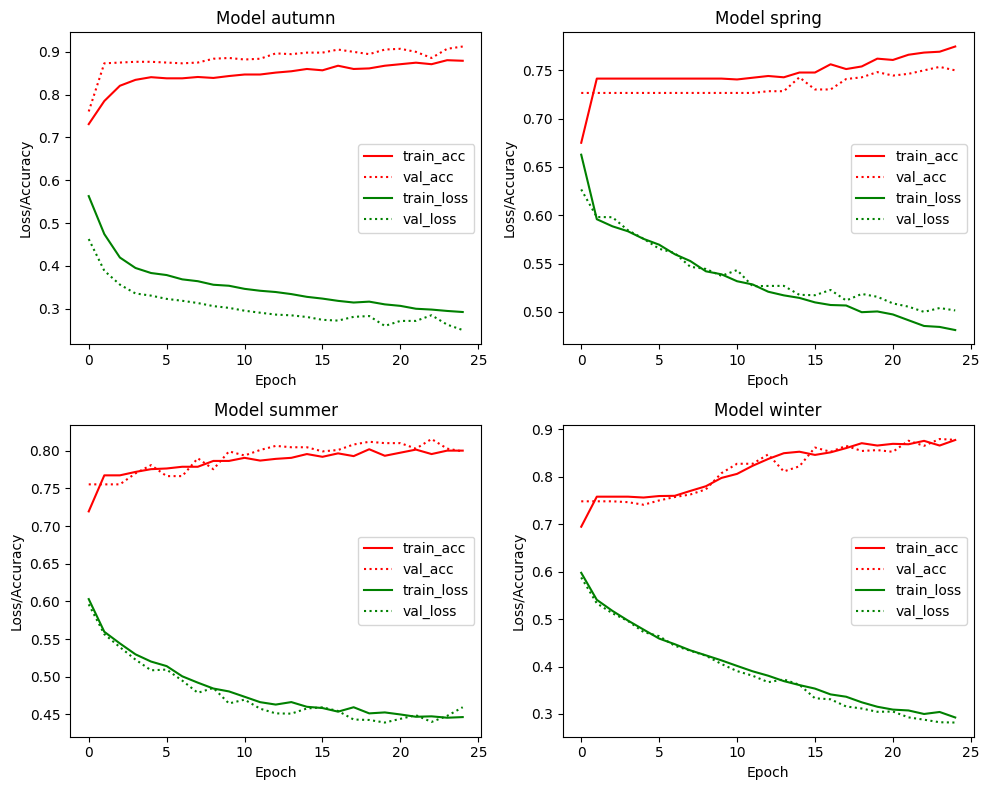

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

for i, history in enumerate(histories):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    ax.plot(history[1].history['accuracy'], label='train_acc', color='red')
    ax.plot(history[1].history['val_accuracy'], label='val_acc', linestyle=':', color='red')
    ax.plot(history[1].history['loss'], label='train_loss', color='green')
    ax.plot(history[1].history['val_loss'], label='val_loss', linestyle=':', color='green')
    ax.set_title(f"Model {history[0]}")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss/Accuracy")
    ax.legend()

plt.tight_layout()
plt.show()

#Classify an image

In [ ]:
img_path = 'data/autumn.webp'
img_original  = load_img(img_path)
img = load_img(img_path, target_size=(64, 64))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)

In [ ]:
with open('data/autumn_only_split/model_autumn_1.pkl', 'rb') as file:
    model_autumn_1 = pickle.load(file)
with open('data/spring_only_split/model_spring_1.pkl', 'rb') as file:
    model_spring_1 = pickle.load(file)
with open('data/summer_only_split/model_summer_1.pkl', 'rb') as file:
    model_summer_1 = pickle.load(file)
with open('data/winter_only_split/model_winter_1.pkl', 'rb') as file:
    model_winter_1 = pickle.load(file)

In [ ]:
autumn_pred = model_autumn_1.predict(x)[0]
winter_pred = model_winter_1.predict(x)[0]
summer_pred = model_summer_1.predict(x)[0]
spring_pred = model_spring_1.predict(x)[0]

1/1 [==============================] - 0s 106ms/step


In [ ]:
print(autumn_classes)
print(winter_classes)
print(summer_classes)
print(spring_classes)

['autumn', 'rest']
['rest', 'winter']
['rest', 'summer']
['rest', 'spring']


In [ ]:
autumn_pred

array([0.0311395 , 0.96886045], dtype=float32)

In [ ]:
winter_pred

array([0.57072747, 0.4292725 ], dtype=float32)

In [ ]:
summer_pred

array([0.8416848 , 0.15831521], dtype=float32)

In [ ]:
spring_pred

array([0.75556284, 0.24443717], dtype=float32)

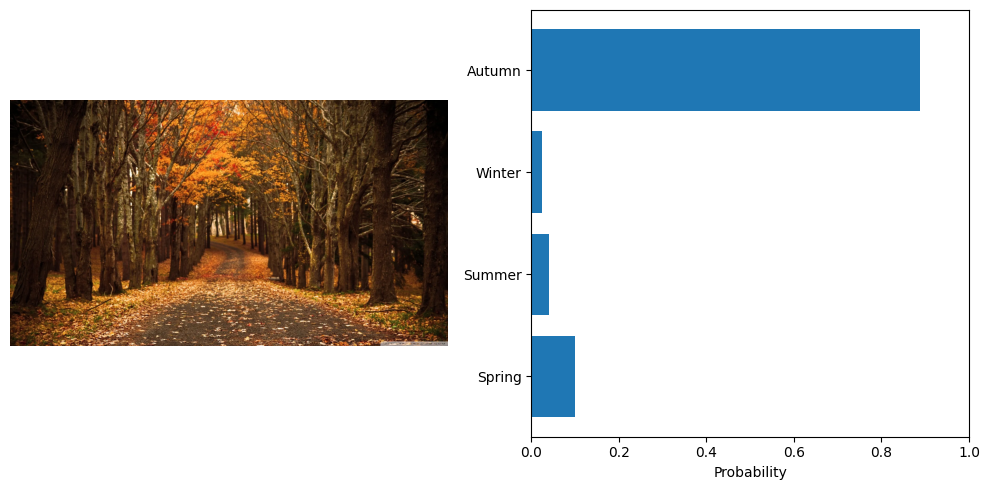

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))
ax1.imshow(img_original)
ax1.axis('off')

labels = ['Autumn', 'Winter', 'Summer', 'Spring']
y_pos = np.arange(len(labels))

ax2.barh(y_pos, [autumn_pred[0], winter_pred[1], summer_pred[1], spring_pred[1]])
ax2.set_yticks(y_pos)
ax2.set_yticklabels(labels)
ax2.invert_yaxis()
ax2.set_xlabel('Probability')
ax2.set_xlim([0, 1])

plt.tight_layout()
plt.show()